In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import numpy as np
import pandas as pd

import csv as csv
import sklearn
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score,KFold,train_test_split,GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import xgboost
import lightgbm as lgb

from utils import save_to_csv, reduce_memory_usage,custom_kfold_scorer 

In [47]:
train_df = pd.read_csv("./train_2.csv")
test_df = pd.read_csv("./test_2.csv")
aux_df = pd.read_csv("./auxiliary-data/sg-primary-schools.csv")

In [48]:
aux_df.head()

,name,lat,lng
0,Admiralty Primary School,1.442941,103.800345
1,Ahmad Ibrahim Primary School,1.433849,103.832710
2,Ai Tong School,1.360713,103.833018
3,Alexandra Primary School,1.291284,103.824066
4,Anchor Green Primary School,1.390380,103.887354


## Check for NULL values

In [49]:
aux_df.isnull().any()

name    False
lat     False
lng     False
dtype: bool

### Checking for duplicate values

In [50]:
aux_df.duplicated().any()

False

### Club latitude and longitude together

In [51]:
aux_df['lat_long'] = list(zip(aux_df.lat, aux_df.lng))

In [52]:
aux_df.head()

,name,lat,lng,lat_long
0,Admiralty Primary School,1.442941,103.800345,"(1.4429413999999998, 103.80034506744822)"
1,Ahmad Ibrahim Primary School,1.433849,103.832710,"(1.4338487, 103.83270977683569)"
2,Ai Tong School,1.360713,103.833018,"(1.36071255, 103.83301753795786)"
3,Alexandra Primary School,1.291284,103.824066,"(1.2912837, 103.82406594082049)"
4,Anchor Green Primary School,1.390380,103.887354,"(1.3903797999999998, 103.88735379337129)"


# ADD SOME PLOTS HERE

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

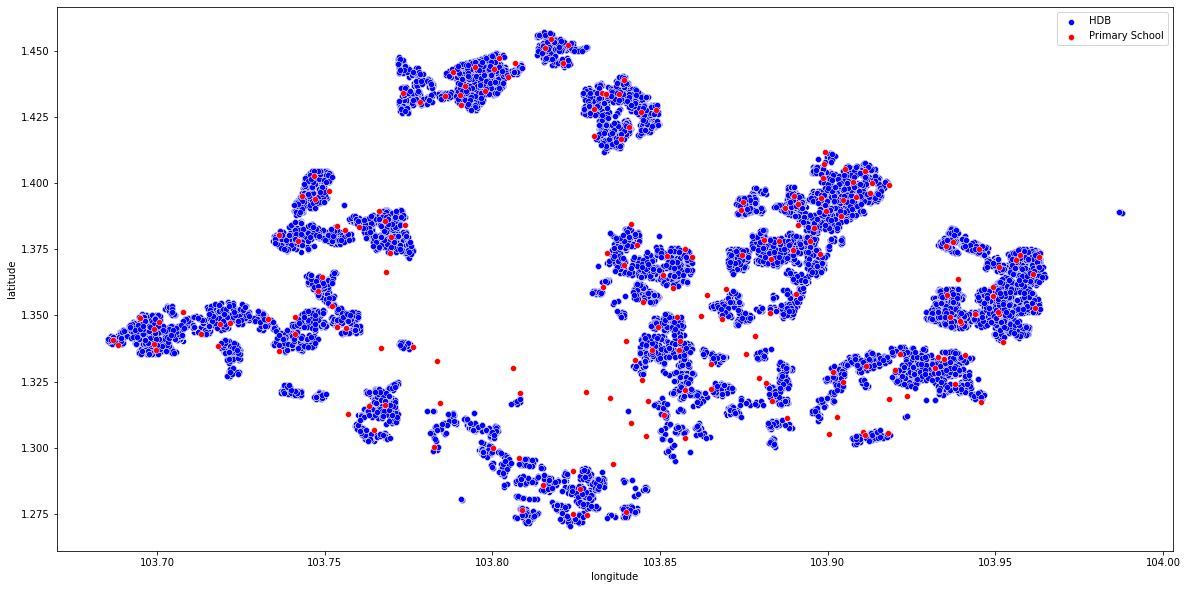

In [53]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=train_df.longitude,y=train_df.latitude,color="blue",label="HDB")
sns.scatterplot(x=aux_df.lng,y=aux_df.lat,color="red",label="Primary School")

### Extract lat_long column from train and test data sets

In [54]:
train_df_temp = train_df[["lat_long"]]
test_df_temp = test_df[["lat_long"]]

### Drop duplicate locations

In [55]:
train_df_temp = train_df_temp.drop_duplicates(subset=['lat_long'])
test_df_temp = test_df_temp.drop_duplicates(subset=['lat_long'])

### Add columns to store the nearest primary school and its distance and number of primary schools in 1km

In [56]:
train_df_temp["nearest_primary_school"] = str("--")
train_df_temp["nearest_primary_school_distance"] = math.inf
train_df_temp["primary_school_1_km"] = 0
test_df_temp["nearest_primary_school"] = str("--")
test_df_temp["nearest_primary_school_distance"] = math.inf
test_df_temp["primary_school_1_km"] = 0
train_df_temp = train_df_temp.reset_index()
test_df_temp = test_df_temp.reset_index()

In [57]:
aux_df = aux_df.drop(columns=['lat','lng'])
aux_df = aux_df.reset_index()

In [58]:
aux_df.head()

,index,name,lat_long
0,0,Admiralty Primary School,"(1.4429413999999998, 103.80034506744822)"
1,1,Ahmad Ibrahim Primary School,"(1.4338487, 103.83270977683569)"
2,2,Ai Tong School,"(1.36071255, 103.83301753795786)"
3,3,Alexandra Primary School,"(1.2912837, 103.82406594082049)"
4,4,Anchor Green Primary School,"(1.3903797999999998, 103.88735379337129)"


In [59]:
train_df_temp.head()

,index,lat_long,nearest_primary_school,nearest_primary_school_distance,primary_school_1_km
0,0,"(1.3690080642700195, 103.95869445800781)",--,inf,0
1,1,"(1.3990070819854736, 103.90699005126953)",--,inf,0
2,2,"(1.3883482217788696, 103.87381744384766)",--,inf,0
3,3,"(1.3184930086135864, 103.7667007446289)",--,inf,0
4,4,"(1.3481495380401611, 103.74266052246094)",--,inf,0


In [60]:
test_df_temp.head()

,index,lat_long,nearest_primary_school,nearest_primary_school_distance,primary_school_1_km
0,0,"(1.3465807437896729, 103.74408721923828)",--,inf,0
1,1,"(1.3576176166534424, 103.96138000488281)",--,inf,0
2,2,"(1.337803840637207, 103.74199676513672)",--,inf,0
3,3,"(1.380083680152893, 103.84957122802734)",--,inf,0
4,4,"(1.3139597177505493, 103.76982879638672)",--,inf,0


Converting our dataframe to numpy arrays for faster computation

In [61]:
train_df_temp_numpy = train_df_temp.to_numpy()
test_df_temp_numpy = test_df_temp.to_numpy()
aux_df_numpy = aux_df.to_numpy()

In [62]:
print("Shape of train_df_temp_numpy :",np.shape(train_df_temp_numpy))
print("Shape of test_df_temp_numpy :",np.shape(test_df_temp_numpy))
print("Shape of aux_df_numpy :",np.shape(aux_df_numpy))

Shape of train_df_temp_numpy : (9138, 5)
Shape of test_df_temp_numpy : (8990, 5)
Shape of aux_df_numpy : (191, 3)


## Get the nearest primary school and its distance from HDB. Also count the number of primary schools within 1km from HDB

In [63]:
%%time
print("Get distance for each location and update nearest primary school and its distance")
for i in range(len(train_df_temp_numpy)):
    min_dist = math.inf
    min_dist_aux = ""
    hdb_location = train_df_temp_numpy[i][1]
    hdb_location = eval(hdb_location)
    count = 0
    for j in range(len(aux_df_numpy)):
        aux_location = aux_df_numpy[j][2]
        distance = geopy.distance.great_circle(hdb_location, aux_location).km
        if distance < min_dist:
            min_dist = distance
            min_dist_mrt = aux_df_numpy[j][1]
        if distance <= 1:
            count+=1
    train_df_temp_numpy[i][2] = min_dist_mrt
    train_df_temp_numpy[i][3] = min_dist
    train_df_temp_numpy[i][4] = count

print("Add nearest_primary_school and nearest_primary_school_distance and count of primary schools in 1 km to dataframe")
for i in range(len(train_df_temp_numpy)):
    dataframe_index = train_df_temp_numpy[i][0]
    train_df_temp.loc[i, "nearest_primary_school"] = train_df_temp_numpy[i][2]
    train_df_temp.loc[i, "nearest_primary_school_distance"] = train_df_temp_numpy[i][3]
    train_df_temp.loc[i, "primary_school_1_km"] = train_df_temp_numpy[i][4]

Get distance for each location and update nearest primary school and its distance
Add nearest_primary_school and nearest_primary_school_distance and count of primary schools in 1 km to dataframe
Wall time: 24 s


In [64]:
%%time
print("Get distance for each location and update nearest primary school and its distance")
for i in range(len(test_df_temp_numpy)):
    min_dist = math.inf
    min_dist_aux = ""
    hdb_location = test_df_temp_numpy[i][1]
    hdb_location = eval(hdb_location)
    count = 0
    for j in range(len(aux_df_numpy)):
        aux_location = aux_df_numpy[j][2]
        distance = geopy.distance.great_circle(hdb_location, aux_location).km
        if distance < min_dist:
            min_dist = distance
            min_dist_mrt = aux_df_numpy[j][1]
        if distance <= 0.5:
            count+=1
    test_df_temp_numpy[i][2] = min_dist_mrt
    test_df_temp_numpy[i][3] = min_dist
    test_df_temp_numpy[i][4] = count

print("Add nearest_primary_school and nearest_primary_school_distance and count of primary schools in 1 km to HDB")
for i in range(len(test_df_temp_numpy)):
    dataframe_index = test_df_temp_numpy[i][0]
    test_df_temp.loc[i, "nearest_primary_school"] = test_df_temp_numpy[i][2]
    test_df_temp.loc[i, "nearest_primary_school_distance"] = test_df_temp_numpy[i][3]
    test_df_temp.loc[i, "primary_school_1_km"] = test_df_temp_numpy[i][4]

Get distance for each location and update nearest primary school and its distance
Add nearest_primary_school and nearest_primary_school_distance and count of primary schools in 1 km to HDB
Wall time: 24.7 s


In [65]:
train_df_temp.head()

,index,lat_long,nearest_primary_school,nearest_primary_school_distance,primary_school_1_km
0,0,"(1.3690080642700195, 103.95869445800781)",Loyang Primary School,0.343899,5
1,1,"(1.3990070819854736, 103.90699005126953)",Edgefield Primary School,0.160876,8
2,2,"(1.3883482217788696, 103.87381744384766)",Fernvale Primary School,0.184837,2
3,3,"(1.3184930086135864, 103.7667007446289)",Pei Tong Primary School,0.304605,2
4,4,"(1.3481495380401611, 103.74266052246094)",Princess Elizabeth Primary School,0.234022,2


In [66]:
test_df_temp.head()

,index,lat_long,nearest_primary_school,nearest_primary_school_distance,primary_school_1_km
0,0,"(1.3465807437896729, 103.74408721923828)",Princess Elizabeth Primary School,0.467265,1
1,1,"(1.3576176166534424, 103.96138000488281)",East Spring Primary School,0.530009,0
2,2,"(1.337803840637207, 103.74199676513672)",Yuhua Primary School,0.577321,0
3,3,"(1.380083680152893, 103.84957122802734)",Mayflower Primary School,0.799739,0
4,4,"(1.3139597177505493, 103.76982879638672)",Pei Tong Primary School,0.316697,1


### We will now merge the result with our original data frames

In [67]:
temp = train_df_temp[["lat_long", "nearest_primary_school", "nearest_primary_school_distance","primary_school_1_km"]]
train_df = pd.merge(train_df, temp, on="lat_long", how='left')

temp = test_df_temp[["lat_long", "nearest_primary_school", "nearest_primary_school_distance","primary_school_1_km"]]
test_df = pd.merge(test_df, temp, on="lat_long", how='left')

### Nearest Primary school and its distance from HDB has been added to our dataframe

In [68]:
train_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,planning_area,region,resale_price,month_no,year,storey,lat_long,nearest_primary_school,nearest_primary_school_distance,primary_school_1_km
0,pasir ris,4-room,440,pasir ris drive 4,118.0,model a,1989,1.369008,103.958694,pasir ris drive,pasir ris,east region,209700.0,8,2001,2.0,"(1.3690080642700195, 103.95869445800781)",Loyang Primary School,0.343899,5
1,punggol,5-room,196B,punggol field,110.0,improved,2003,1.399007,103.906990,punggol field,punggol,north-east region,402300.0,10,2014,11.0,"(1.3990070819854736, 103.90699005126953)",Edgefield Primary School,0.160876,8
2,sengkang,5-room,404A,fernvale lane,112.0,premium apartment,2004,1.388348,103.873820,fernvale,sengkang,north-east region,351000.0,9,2020,2.0,"(1.3883482217788696, 103.87381744384766)",Fernvale Primary School,0.184837,2
3,clementi,3-room,375,clementi avenue 4,67.0,new generation,1980,1.318493,103.766700,clementi north,clementi,west region,151200.0,10,2000,8.0,"(1.3184930086135864, 103.7667007446289)",Pei Tong Primary School,0.304605,2
4,bukit batok,3-room,163,bukit batok street 11,73.0,model a,1985,1.348150,103.742660,bukit batok west,bukit batok,west region,318600.0,1,2013,8.0,"(1.3481495380401611, 103.74266052246094)",Princess Elizabeth Primary School,0.234022,2


In [69]:
test_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,planning_area,region,month_no,year,storey,lat_long,nearest_primary_school,nearest_primary_school_distance,primary_school_1_km
0,bukit batok,4-room,186,bukit batok west avenue 6,94.0,new generation,1989,1.346581,103.74409,bukit batok west,bukit batok,west region,1,2004,5.0,"(1.3465807437896729, 103.74408721923828)",Princess Elizabeth Primary School,0.467265,1
1,tampines,5-room,366,tampines street 34,122.0,improved,1997,1.357618,103.96138,tampines east,tampines,east region,11,2001,5.0,"(1.3576176166534424, 103.96138000488281)",East Spring Primary School,0.530009,0
2,jurong east,3-room,206,jurong east street 21,67.0,new generation,1982,1.337804,103.74200,toh guan,jurong east,west region,7,2002,2.0,"(1.337803840637207, 103.74199676513672)",Yuhua Primary School,0.577321,0
3,ang mo kio,3-room,180,Ang Mo Kio Avenue 5,82.0,new generation,1981,1.380084,103.84957,yio chu kang east,ang mo kio,north-east region,4,2015,5.0,"(1.380083680152893, 103.84957122802734)",Mayflower Primary School,0.799739,0
4,clementi,5-room,356,clementi avenue 2,117.0,standard,1978,1.313960,103.76983,clementi north,clementi,west region,4,2004,2.0,"(1.3139597177505493, 103.76982879638672)",Pei Tong Primary School,0.316697,1


# ADD SOME PLOTS HERE

<AxesSubplot:>

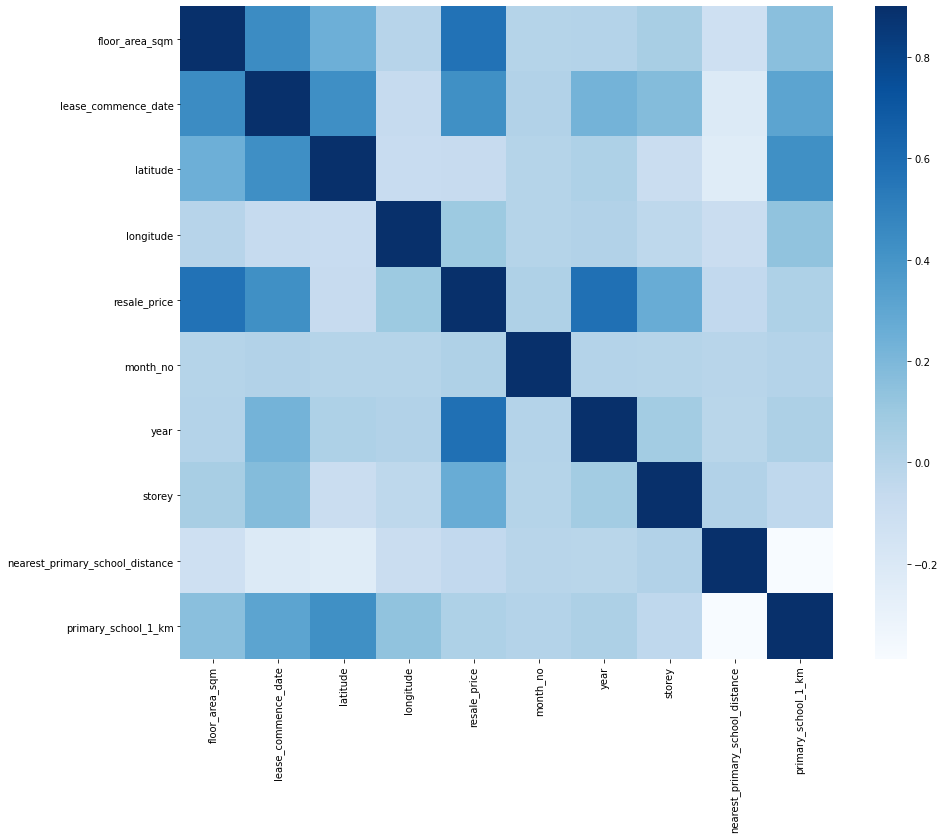

In [70]:
corr = train_df.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [71]:
corr[['resale_price']].sort_values(by='resale_price',ascending=False).style.background_gradient(cmap='viridis', axis=None)

,resale_price
resale_price,1.000000
year,0.578717
floor_area_sqm,0.570385
lease_commence_date,0.423578
storey,0.269431
longitude,0.099786
primary_school_1_km,0.030717
month_no,0.025448
nearest_primary_school_distance,-0.045561
latitude,-0.065915


### Reduce the size of dataframe to save memory during training

In [72]:
train_df, _ = reduce_memory_usage(train_df)
test_df, _ = reduce_memory_usage(test_df)

Memory usage of properties dataframe is : 69.17092895507812  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  47.34914779663086  MB
This is  68.45238095238095 % of the initial size
Memory usage of properties dataframe is : 16.46942138671875  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  11.425661087036133  MB
This is  69.375 % of the initial size


### Segregate the columns

In [73]:
integer_columns = [
    "lease_commence_date",
    "storey",
    "month_no",
    "year",
    "nearest_primary_school_distance",
    "nearest_primary_school_1_km"
]

float_columns = [
    "floor_area_sqm",
]

target_column = [
    "resale_price"
]

## Categorical columns need to be encoded before training
categorical_columns = [
    "town",
    "flat_type",
    "flat_model",
    "subzone",
    "planning_area",
    "region"
]

## We will drop these columns before training
drop_columns = [
    "lat_long",
    "block",
    "street_name",
    "nearest_primary_school",
    "longitude",
    "latitude"
]

### Drop the selected columns

In [74]:
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

In [75]:
train_df.head()

,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,subzone,planning_area,region,resale_price,month_no,year,storey,nearest_primary_school_distance,primary_school_1_km
0,pasir ris,4-room,118.0,model a,1989,pasir ris drive,pasir ris,east region,209700.0,8,2001,2,0.343899,5
1,punggol,5-room,110.0,improved,2003,punggol field,punggol,north-east region,402300.0,10,2014,11,0.160876,8
2,sengkang,5-room,112.0,premium apartment,2004,fernvale,sengkang,north-east region,351000.0,9,2020,2,0.184837,2
3,clementi,3-room,67.0,new generation,1980,clementi north,clementi,west region,151200.0,10,2000,8,0.304605,2
4,bukit batok,3-room,73.0,model a,1985,bukit batok west,bukit batok,west region,318600.0,1,2013,8,0.234022,2


In [76]:
test_df.head()

,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,subzone,planning_area,region,month_no,year,storey,nearest_primary_school_distance,primary_school_1_km
0,bukit batok,4-room,94.0,new generation,1989,bukit batok west,bukit batok,west region,1,2004,5,0.467265,1
1,tampines,5-room,122.0,improved,1997,tampines east,tampines,east region,11,2001,5,0.530009,0
2,jurong east,3-room,67.0,new generation,1982,toh guan,jurong east,west region,7,2002,2,0.577321,0
3,ang mo kio,3-room,82.0,new generation,1981,yio chu kang east,ang mo kio,north-east region,4,2015,5,0.799739,0
4,clementi,5-room,117.0,standard,1978,clementi north,clementi,west region,4,2004,2,0.316697,1


### One hot encode categorical columns

In [77]:
for col in categorical_columns:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[col], prefix=col)],axis=1)
train_df = train_df.drop(columns=categorical_columns)

for col in categorical_columns:
    test_df = pd.concat([test_df, pd.get_dummies(test_df[col], prefix=col)],axis=1)
test_df = test_df.drop(columns=categorical_columns)

### Check if the columns in both test data and train data are same after one-hot encoding

In [78]:
columns_in_test_not_in_train = test_df.columns.difference(train_df.columns).tolist()
#print(columns_in_test_not_in_train)
columns_in_train_not_in_test = train_df.columns.difference((test_df.columns)).tolist()
columns_in_train_not_in_test.remove('resale_price')
#print(columns_in_train_not_in_test)
if not columns_in_test_not_in_train and not columns_in_train_not_in_test:
    print("Columns are same")

Columns are same


### Split training data into training and validation sets

In [79]:
train_data = train_df.sample(frac=1)
train_labels = train_data.pop('resale_price')
train_x, val_x, train_y, val_y = train_test_split(train_data,train_labels,train_size=0.8)

## Decision Tree

In [80]:
dt_1 = tree.DecisionTreeRegressor()

In [81]:
%%time
dt_1 = dt_1.fit(train_x, train_y)

Wall time: 11 s


In [82]:
train_prediction = dt_1.predict(train_x)
val_prediction = dt_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 1465.137513470842
Validation error(RMSE) : 25750.953145117117
R2 score for training data : 0.9998725942117531
R2 score for validation data : 0.9608227709921568


In [83]:
dt_2 = tree.DecisionTreeRegressor(max_depth=30,min_samples_split=30)

In [84]:
%%time
dt_2 = dt_2.fit(train_x, train_y)

Wall time: 10.8 s


In [85]:
train_prediction = dt_2.predict(train_x)
val_prediction = dt_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 17656.46046671308
Validation error(RMSE) : 22796.219151881898
R2 score for training data : 0.9814971053766388
R2 score for validation data : 0.9692975703580471


In [86]:
%%time
dt_3 = tree.DecisionTreeRegressor(max_depth=250,min_samples_split=15)
dt_3 = dt_3.fit(train_x, train_y)

Wall time: 8.76 s


In [87]:
train_prediction = dt_3.predict(train_x)
val_prediction = dt_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 14143.609937623576
Validation error(RMSE) : 22952.358966033873
R2 score for training data : 0.9881272062392104
R2 score for validation data : 0.9688755451849724


#### Uncomment next block to make prediction on test data and generate csv

In [112]:
#test_result = rf_1.predict(test_df)
#save_to_csv(test_result,"./primary_school_dt_3_result.csv")

## Random Forest

In [88]:
rf_1 = RandomForestRegressor()

In [89]:
%%time
rf_1.fit(train_x,train_y)

Wall time: 11min 37s


RandomForestRegressor()

In [90]:
train_prediction = rf_1.predict(train_x)
val_prediction = rf_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 7099.7372792266015
Validation error(RMSE) : 18745.524049302803
R2 score for training data : 0.99700830759259
R2 score for validation data : 0.9792392867443824


#### Uncomment next block to make prediction on test data and generate csv

In [109]:
#test_result = rf_1.predict(test_df)
#save_to_csv(test_result,"./primary_school_rf_1_result.csv")

## XGBOOST

In [91]:
xgb_model_1 = xgboost.XGBRegressor()

In [92]:
%%time
xgb_model_1.fit(train_x,train_y)

Wall time: 49.4 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [93]:
train_prediction = xgb_model_1.predict(train_x)
val_prediction = xgb_model_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 21338.605
Validation error(RMSE) : 21951.797
R2 score for training data : 0.9729750761859908
R2 score for validation data : 0.9715300124348025


In [94]:
xgb_model_2 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=50,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [95]:
%%time
xgb_model_2.fit(train_x,train_y)

Wall time: 3min 51s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=50,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [96]:
train_prediction = xgb_model_2.predict(train_x)
val_prediction = xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 11809.001
Validation error(RMSE) : 22330.701
R2 score for training data : 0.9917232711098529
R2 score for validation data : 0.9705387074711758


#### Uncomment next block to make prediction on test data and generate csv

In [111]:
#test_result = xgb_model_2.predict(test_df)
#save_to_csv(test_result,"./primary_school_xgb_model_2_result.csv")

## LightGBM

In [97]:
gbm_1 = lgb.LGBMRegressor()

In [98]:
%%time
gbm_1 = gbm_1.fit(train_x,train_y)

Wall time: 2.36 s


In [99]:
train_prediction = gbm_1.predict(train_x)
val_prediction = gbm_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 24391.114582759245
Validation error(RMSE) : 24599.15423549105
R2 score for training data : 0.964690166024719
R2 score for validation data : 0.9642490613346004


In [100]:
gbm_2 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=10000,n_estimators=10000)

In [101]:
%%time
gbm_2 = gbm_2.fit(train_x,train_y)

Wall time: 44.3 s


In [102]:
train_prediction = gbm_2.predict(train_x)
val_prediction = gbm_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 11858.337283013816
Validation error(RMSE) : 16301.17376494586
R2 score for training data : 0.9916539692571669
R2 score for validation data : 0.9843005350446461


#### Uncomment next block to make prediction on test data and generate csv

In [110]:
#test_result = gbm_2.predict(test_df)
#save_to_csv(test_result,"./primary_school_gbm_2_result.csv")

## Prediction using Random Forest, XGBOOST and LightGBM together

In [105]:
train_prediction = 0.4*gbm_2.predict(train_x) + 0.4*rf_1.predict(train_x) +0.2*xgb_model_2.predict(train_x)
val_prediction = 0.4*gbm_2.predict(val_x)+ 0.4*rf_1.predict(val_x) +0.2*xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 9010.921291743885
Validation error(RMSE) : 16845.630594532504
R2 score for training data : 0.995180846327625
R2 score for validation data : 0.9832343018162975


#### Uncomment next block to make prediction on test data and generate csv

In [107]:
#test_result = 0.4*gbm_2.predict(test_df) + 0.4*rf_1.predict(test_df) +0.2*xgb_model_2.predict(test_df)
#save_to_csv(test_result,"./primary_school_gbm_2_xgb_model_2_rf_1_result.csv")